# Part 2: Best models

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Load processed data
df = pd.read_csv('train_processed.csv')  

# ==============================================================================
# DATA PREPARATION & SPLIT
# ==============================================================================

# Define Features (X) and Target (y)
X = df.drop(['target', 'UNIQUE_ID', 'Insee', 'work_desc', 'former_work_desc'], axis=1)
y = df['target']

# Categorical Encoding (Category Codes)
cats = X.select_dtypes(include=['object', 'category']).columns
for col in cats:
    X[col] = X[col].astype('category').cat.codes

# Handle Missing Values for XGBoost
X = X.fillna(-1)

# Target Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"✅ Data Ready. Train shape: {X_train.shape}, Test shape: {X_test.shape}")

✅ Data Ready. Train shape: (40036, 42), Test shape: (10010, 42)


/var/folders/l0/l3b41n5n00z588bsfcg0b5040000gn/T/ipykernel_67741/2310956882.py:9: DtypeWarning: Columns (4,20,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_processed.csv')


### Simple decision tree to get a baseline for our XGBoost model

In [2]:
from sklearn.tree import DecisionTreeClassifier

# ==============================================================================
# BASELINE: DECISION TREE
# ==============================================================================

dt_base = DecisionTreeClassifier(random_state=42, criterion='gini')

param_grid = {
    'max_depth': [3, 5, 8, 12, 20],
    'min_samples_leaf': [5, 20, 50]
}

# Utilisation de StratifiedKFold (défini précédemment ou réinstancié ici pour sûreté)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_dt = GridSearchCV(dt_base, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

# Résultats
print(f"Best Parameters: {grid_dt.best_params_}")
print(f"Baseline Accuracy: {accuracy_score(y_test, y_pred_dt):.2%}\n")

target_names = [str(cls) for cls in le.classes_]
print(classification_report(y_test, y_pred_dt, target_names=target_names))

Best Parameters: {'max_depth': 12, 'min_samples_leaf': 50}
Baseline Accuracy: 72.78%

              precision    recall  f1-score   support

           L       0.73      0.79      0.76      5391
           T       0.73      0.65      0.69      4619

    accuracy                           0.73     10010
   macro avg       0.73      0.72      0.72     10010
weighted avg       0.73      0.73      0.73     10010



# Comparison between XGBoost and Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier

# ==============================================================================
# RANDOM FOREST GRIDSEARCH
# ==============================================================================

rf_base = RandomForestClassifier(random_state=42, n_jobs=2)

param_grid = {
    'n_estimators': [150, 250],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(rf_base, param_grid, cv=cv, scoring='f1', n_jobs=-2, verbose=1)
grid_rf.fit(X_train, y_train)

best_model_rf = grid_rf.best_estimator_

# Stability Analysis
results = pd.DataFrame(grid_rf.cv_results_)
results['se_test_score'] = results['std_test_score'] / np.sqrt(5)

cols = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
        'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'se_test_score']

summary = results[cols].sort_values(by='mean_test_score', ascending=False).head(10)
summary.columns = ['Paramètres', 'F1 Pli 1', 'F1 Pli 2', 'F1 Pli 3', 'F1 Pli 4', 'F1 Pli 5', 'F1 Moyen', 'Ecart-Type', 'Erreur Std']

pd.set_option('display.max_colwidth', 100)
print("Stability Analysis (Top 10 RF Configurations):")
print(summary.to_string(index=False))

# Final Metrics
y_pred_rf = best_model_rf.predict(X_test)
target_names = [str(cls) for cls in le.classes_]

print(f"\nFinal RF Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}\n")
print(classification_report(y_test, y_pred_rf, target_names=target_names))

print("Top Feature Importance:")
print(pd.Series(best_model_rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Stability Analysis (Top 10 RF Configurations):
                                                                                 Paramètres  F1 Pli 1  F1 Pli 2  F1 Pli 3  F1 Pli 4  F1 Pli 5  F1 Moyen  Ecart-Type  Erreur Std
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 250}  0.713258  0.701252  0.713383  0.714780  0.719238  0.712382    0.005973    0.002671
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 150}  0.713594  0.700593  0.716188  0.715076  0.716298  0.712350    0.005959    0.002665
  {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 250}  0.715947  0.704097  0.714426  0.712146  0.713198  0.711963    0.004132    0.001848
  {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 150}  0.714385  0.701754  0.715310  0.710519  0.713279  0.711049    0.004918    0.002199
{'class_wei

## Best model for the train set (XGBoost)

In [17]:
import xgboost as xgb

# ==============================================================================
# XGBOOST GRIDSEARCH (F1-SCORE OPTIMIZATION)
# ==============================================================================

xgb_base = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-2,  # Optimization for Apple Silicon M3 (keeps 1-2 cores free)
    eval_metric='logloss',
    tree_method='hist'
)

param_grid = {
    'n_estimators': [150, 250],
    'max_depth': [4, 6, 8, 0],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [1, 1.2] 
}

# Re-using the CV strategy defined earlier
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(xgb_base, param_grid, cv=cv, scoring='f1', n_jobs=-2, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

# Stability Analysis
results = pd.DataFrame(grid.cv_results_)
results['se_test_score'] = results['std_test_score'] / np.sqrt(5)

cols = ['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 
        'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'se_test_score']

summary = results[cols].sort_values(by='mean_test_score', ascending=False).head(10)
summary.columns = ['Paramètres', 'F1 Pli 1', 'F1 Pli 2', 'F1 Pli 3', 'F1 Pli 4', 'F1 Pli 5', 'F1 Moyen', 'Ecart-Type', 'Erreur Std']

pd.set_option('display.max_colwidth', 100)
print("Stability Analysis (Top 10 XGBoost Configurations):")
print(summary.to_string(index=False))

# Final Metrics
y_pred = best_model.predict(X_test)
target_names = [str(cls) for cls in le.classes_]

print(f"\nFinal XGBoost Accuracy: {accuracy_score(y_test, y_pred):.2%}\n")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Top Feature Importance:")
print(pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Stability Analysis (Top 10 XGBoost Configurations):
                                                                           Paramètres  F1 Pli 1  F1 Pli 2  F1 Pli 3  F1 Pli 4  F1 Pli 5  F1 Moyen  Ecart-Type  Erreur Std
 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150, 'scale_pos_weight': 1.2}  0.727398  0.729604  0.729711  0.731027  0.734945  0.730537    0.002493    0.001115
{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 250, 'scale_pos_weight': 1.2}  0.729919  0.730523  0.727474  0.729911  0.730780  0.729721    0.001174    0.000525
 {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 250, 'scale_pos_weight': 1.2}  0.724590  0.729453  0.727424  0.729161  0.732502  0.728626    0.002597    0.001162
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 250, 'scale_pos_weight': 1.2}  0.730297  0.722283  0.724917  0.728038  0.732067  0.727521    0.003546    0.001586
{'learning_rate': 0.05, 'max_depth':

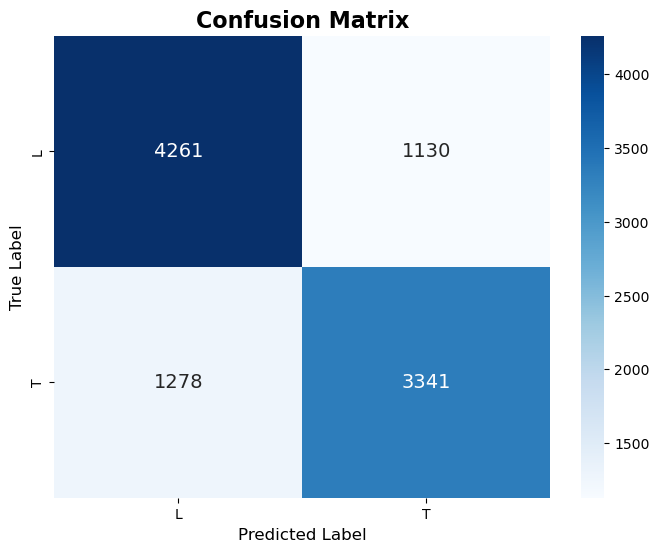

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# VISUALISATION 1 : CONFUSION MATRIX
# ==============================================================================
plt.figure(figsize=(8, 6))

# Calcul des prédictions
y_pred_final = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

# Tracé Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, 
            annot_kws={"size": 14})

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

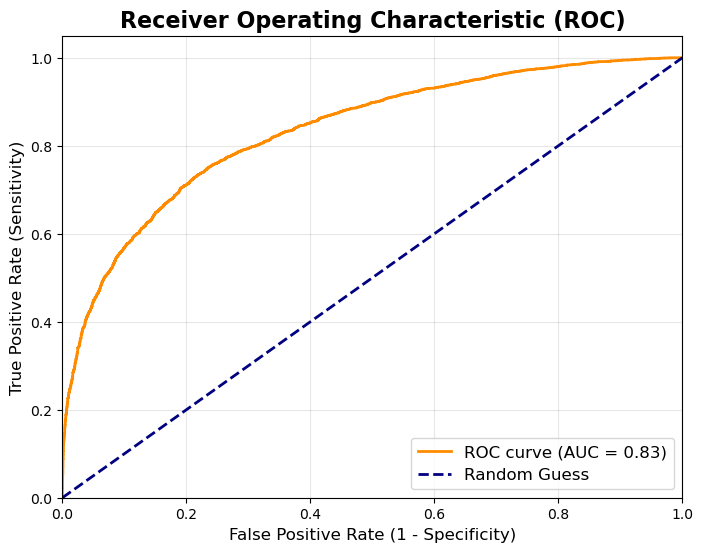

In [ ]:
from sklearn.metrics import roc_curve, auc

# ==============================================================================
# VISUALISATION 2 : ROC CURVE
# ==============================================================================
plt.figure(figsize=(8, 6))

# On a besoin des probabilités pour la courbe ROC
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calcul des métriques
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Tracé
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

/var/folders/l0/l3b41n5n00z588bsfcg0b5040000gn/T/ipykernel_58510/1531013055.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_imp, palette='viridis')


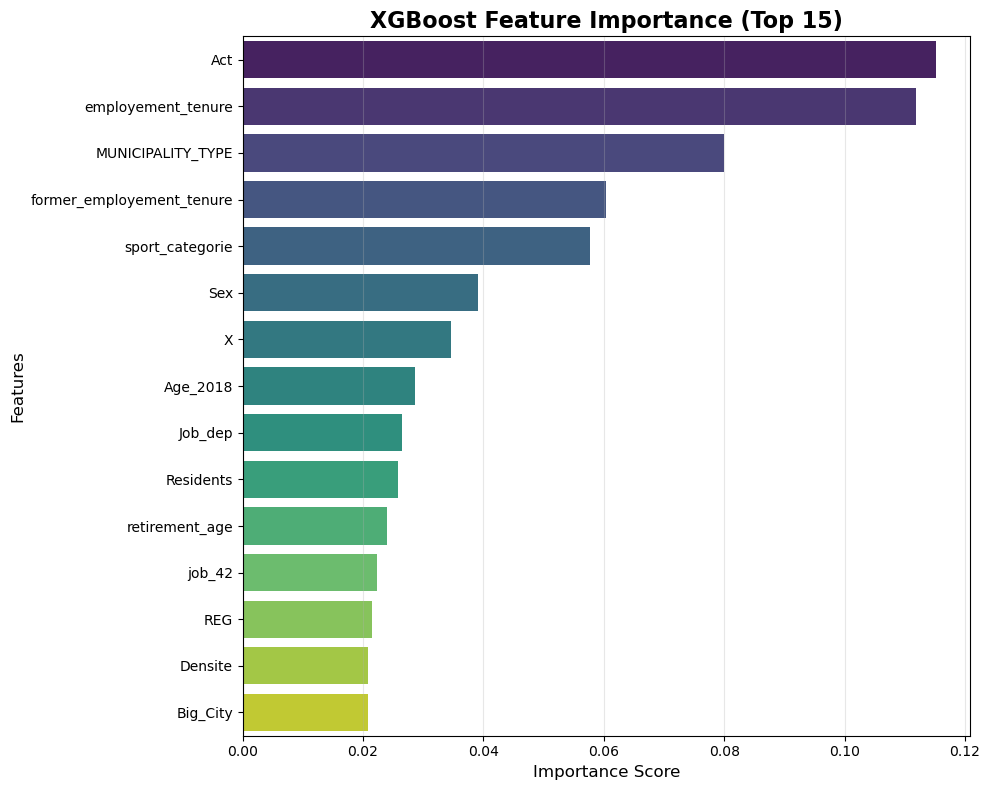

In [ ]:
# ==============================================================================
# VISUALISATION 3 : FEATURE IMPORTANCE
# ==============================================================================
plt.figure(figsize=(10, 8))

# 1. On récupère les importances du modèle (XGBoost)
# Attention : assure-toi que 'best_model' est bien ton modèle XGBoost entraîné
importances = best_model.feature_importances_
feature_names = X.columns  # Les noms des colonnes

# 2. On crée un DataFrame pour trier facile
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_imp = df_imp.sort_values(by='importance', ascending=False).head(15) # Top 15

# 3. Tracé du graphique
sns.barplot(x='importance', y='feature', data=df_imp, palette='viridis')

plt.title('XGBoost Feature Importance (Top 15)', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()